# Cerinta 1 - Reprezentarea modelului de clasificare

In [1]:
from functools import reduce
from json import dumps
from math import inf, log
import matplotlib.pyplot as plt
from operator import add
from os import listdir
from os.path import basename
from random import shuffle
from statistics import mean

from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from spacy import load

download('wordnet')
download('punkt')
download('stopwords')

[nltk_data] Downloading package wordnet to /home/teo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/teo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/teo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
class NewsSummarisationModel:
    def __init__(self, stop_words_file, elim_stops, lemmatise, n_grams):
        self._ALPHA = 1
        self._chars_to_remove = '012345679.,-~`|\\/:;\'"?![]()\n\"'
        self.elim_stops = elim_stops
        self.lemmatise = lemmatise
        self.n_grams = n_grams

        self.class_words = {}
        self.class_app = {}
        self.total_words = {}
        self.total_sents = {}

        self.stop_pos = {'PART', 'DET', 'PUNCT', 'AUX'}

        self.wnl = WordNetLemmatizer()
        self.nlp = load('en')

        self.stop_words = set(stopwords.words('english')) | set(' ')
        with open(stop_words_file) as f:
            self.stop_words.union(set(token.replace('\n', '') for token in f))


    def _remove_chars(self, s):
        for ch in self._chars_to_remove:
            s = s.replace(ch, '')
        return s


    def _should_keep_token(self, tok):
        return tok not in self.stop_words if self.elim_stops else True


    def _group_n_grams(self, words):
        return ['|'.join(words[j]
            for j in range(i, i + self.n_grams))
                for i in range(len(words) - self.n_grams + 1)]


    def parse_sents(self, sents, group):
        lems = []
        for sent in sents:
            tokens = word_tokenize(sent) if self.lemmatise else sent.split()
            for tok in tokens:
                if self._should_keep_token(tok):
                    if self.lemmatise:
                        lem = self.wnl.lemmatize(self._remove_chars(tok).lower())
                    else:
                        lem = tok

                    if lem and (
                        not self.elim_stops
                        or lem not in self.stop_words
                    ):
                        lems.append(lem)

        if group:
            return self._group_n_grams(lems)
        return lems


    def _add_lems_to_class(self, lems, clss, cl):
        for lem in lems:
            if lem in self.class_words[clss][cl]:
                self.class_words[clss][cl][lem] += 1
            else:
                self.class_words[clss][cl][lem] = 1


    def add_file_summary(self, file, summ, clss):
        with open(summ) as f:
            summ_str = f.read()
        with open(file) as f:
            file_sent = sent_tokenize(f.read())

        if clss not in self.class_app:
            self.class_app[clss] = {
                True: 0,
                False: 0
            }
            self.class_words[clss] = {
                True: {},
                False: {}
            }
            self.total_words[clss] = {
                True: 0,
                False: 0
            }
            self.total_sents[clss] = 0
            
        file_sent_keep = list(filter(lambda s: s in summ_str, file_sent))
        self.class_app[clss][True] += len(file_sent_keep)
        self.total_sents[clss] += len(file_sent_keep)

        summ_lems = self.parse_sents(file_sent_keep, True)
        self.total_words[clss][True] += len(summ_lems)
        self._add_lems_to_class(summ_lems, clss, True)

        file_sent_drop = list(filter(lambda s: s not in summ_str, file_sent))
        self.class_app[clss][False] += len(file_sent_drop)
        self.total_sents[clss] += len(file_sent_drop)

        drop_lems = self.parse_sents(file_sent_drop, True)
        self.total_words[clss][False] += len(drop_lems)
        self._add_lems_to_class(drop_lems, clss, False)


    def _compute_log_prob(self, word, clss, cl):
        return log(
            (self.class_words[clss][cl].get(word, 0) + self._ALPHA)
            / (self.total_words[clss][cl] + len(self.class_words[clss]) * self._ALPHA)
        )


    def _make_pred(self, sent, clss):
        lems = self.parse_sents([sent], True)
        max_prob = -inf

        for cl in self.class_words[clss]:
            cl_prob = reduce(
                add,
                map(lambda l: self._compute_log_prob(l, clss, cl), lems),
                0
            ) + log(self.class_app[clss][cl] / self.total_sents[clss])

            if max_prob < cl_prob:
                max_prob = cl_prob
                pred = cl

        return pred, max_prob


    def run_inference(self, file, clss):
        with open(file) as f:
            sents = sent_tokenize(f.read())
        keeps = list(map(
            lambda s: self._make_pred(s, clss),
            sents
        ))
        predicted_sents = zip(sents, keeps)

        for pred, _ in keeps:
            if pred:
                return [sent for sent, keep in predicted_sents if keep[0]]

        predicted_sents = list(predicted_sents)
        predicted_sents.sort(key=lambda p: p[1][1])
        return [predicted_sents[0][0]]


    def print(self, file):
        with open(file, 'w') as f:
            f.write("class_app:\n")
            f.write(dumps(self.class_app, indent=4) + '\n')
            f.write("class_words:\n")
            f.write(dumps(self.class_words, indent=4) + '\n')

In [3]:
def _get_train_test_files(path):
    files = []

    for clss in listdir(f'{path}/News Articles'):
        files += list(map(
            lambda f: (
                f'{path}/News Articles/{clss}/{f}',
                f'{path}/Summaries/{clss}/{f}',
                clss
            ),
            listdir(f'{path}/News Articles/{clss}')
        ))
    
    shuffle(files)
    num_files = len(files)
    num_tests = int(num_files / 4)

    test_files = files[:num_tests]
    train_files = files[num_tests:]

    return train_files, test_files, listdir(path)


def _run_tests(model, test_files):
    recalls = []
    precs = []
    
#     print(dumps(model.class_words, indent=4))

    for file, summ, clss in test_files:
        pred_summ = model.run_inference(file, clss)

        pred_lems = set(model.parse_sents(pred_summ, False))
        with open(summ) as f:
            true_sent = sent_tokenize(f.read())
            true_lems = set(model.parse_sents(true_sent, False))
        common_lem = pred_lems & true_lems

        recalls.append(len(common_lem) / len(true_lems))
        precs.append(len(common_lem) / len(pred_lems))

    return mean(recalls), mean(precs)


def _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams):
    plt.figure(figsize=(23,5))
    plt.plot(xs, precs, label='Precision')
    plt.plot(xs, recalls, label='Recall')
    plt.xlabel('Training files', fontsize=20)
    plt.ylabel('Percentage', fontsize=20)
    plt.legend(fontsize=20)

    lem = 'with' if lemmatise else 'without'
    elim = 'with' if elim_stops else 'without'
    plt.title(f'ROUGE-{n_grams} Score {lem} Lemmatisation, {elim} Elimination', fontsize=15)

    plt.grid()
    plt.show()
    
    print(f' Precision {lem} Lemmatisation, {elim} Elimination is: {precs[len(precs) - 1]}')
    print(f' Recall {lem} Lemmatisation, {elim} Elimination is: {recalls[len(recalls) - 1]}')


def train_and_test(path, stop_words_file, elim_stops, lemmatise, n_grams):
    model = NewsSummarisationModel(stop_words_file, elim_stops, lemmatise, n_grams)
    train_files, test_files, classes = _get_train_test_files(path)

    precs = []
    recalls = []
    xs = []
    i = 1

    for file, summ, clss in train_files:
        if i % 100 == 0:
            xs.append(i)
            rec, prec = _run_tests(model, test_files)
            recalls.append(rec)
            precs.append(prec)

        model.add_file_summary(file, summ, clss)
        i += 1

    xs.append(i)
    rec, prec = _run_tests(model, test_files)
    recalls.append(rec)
    precs.append(prec)

    _display_results(xs, precs, recalls, elim_stops, lemmatise, n_grams)

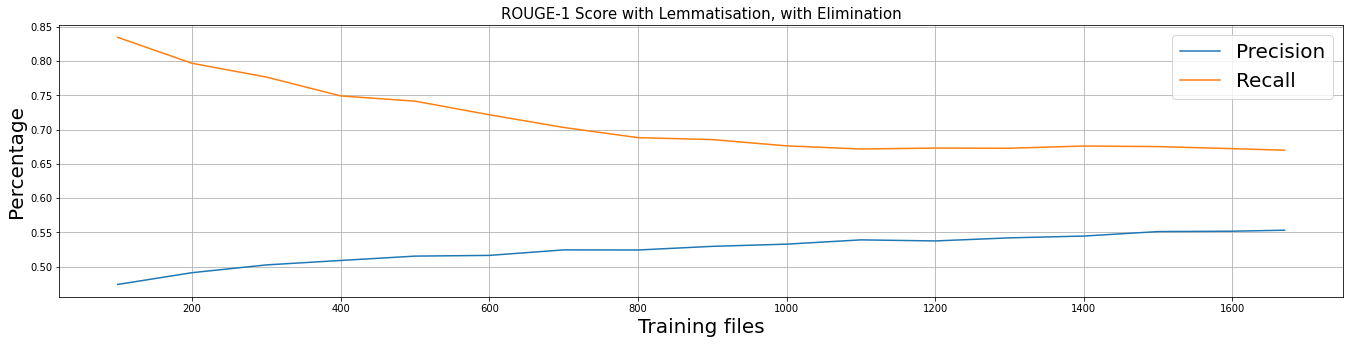

 Precision with Lemmatisation, with Elimination is: 0.5531894513106983
 Recall with Lemmatisation, with Elimination is: 0.6699443115577423


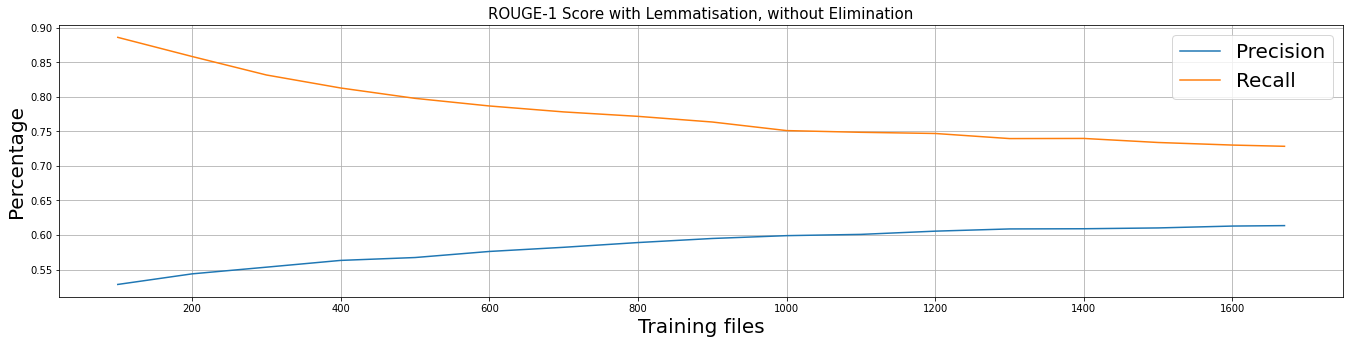

 Precision with Lemmatisation, without Elimination is: 0.6135831038264983
 Recall with Lemmatisation, without Elimination is: 0.7284143183878531


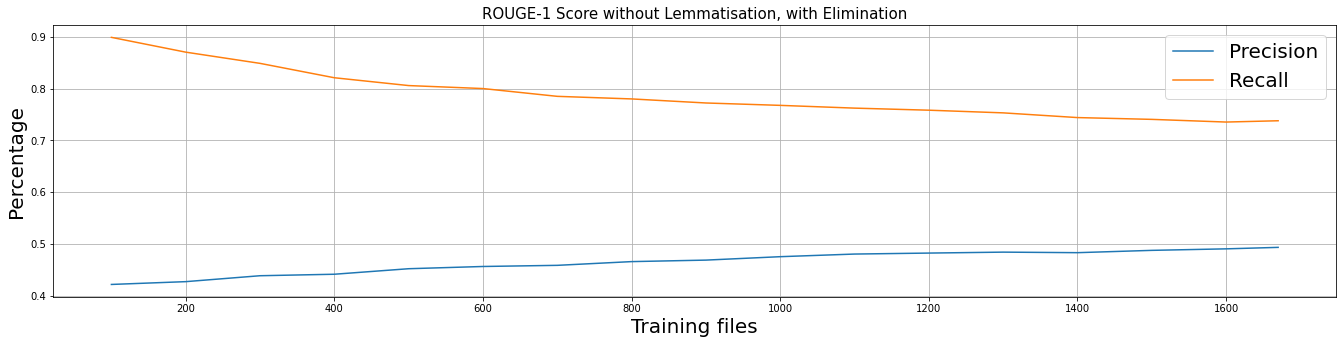

 Precision without Lemmatisation, with Elimination is: 0.49321631963907603
 Recall without Lemmatisation, with Elimination is: 0.7378758347427532


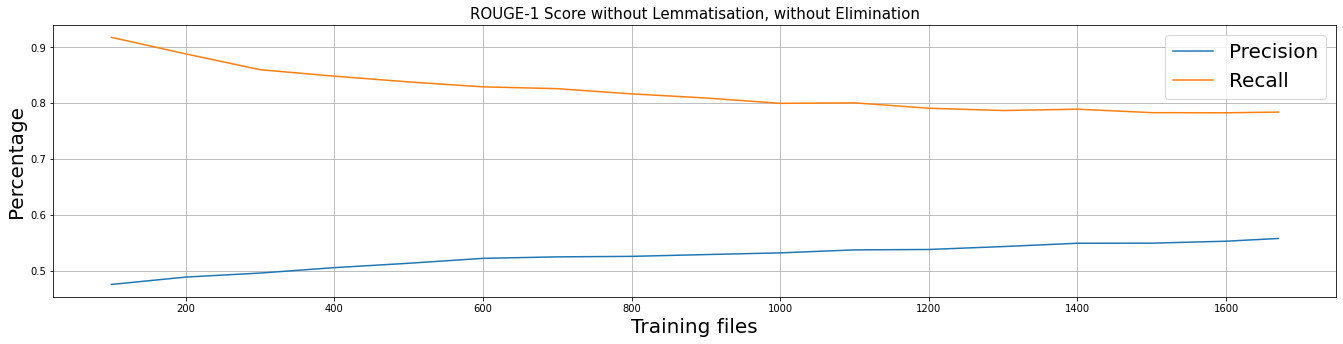

 Precision without Lemmatisation, without Elimination is: 0.5574306884907073
 Recall without Lemmatisation, without Elimination is: 0.7838886881973127


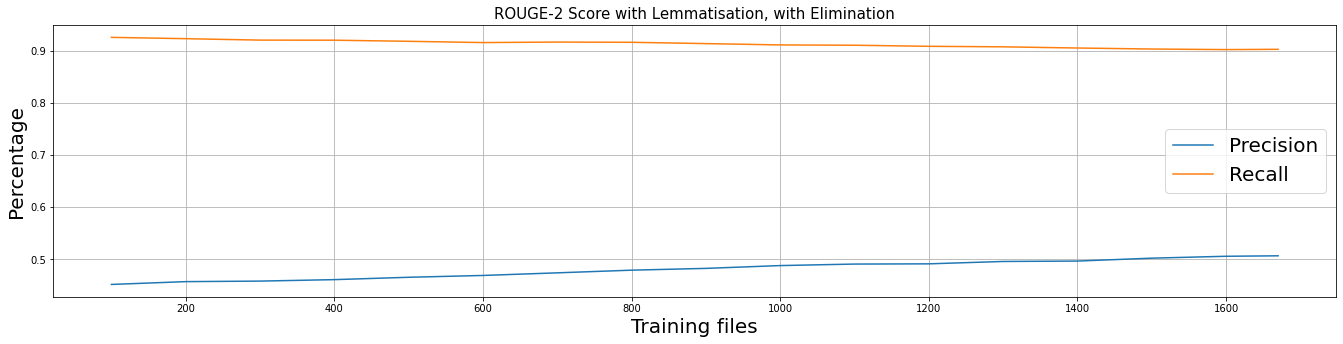

 Precision with Lemmatisation, with Elimination is: 0.5069518643220228
 Recall with Lemmatisation, with Elimination is: 0.9022873865517262


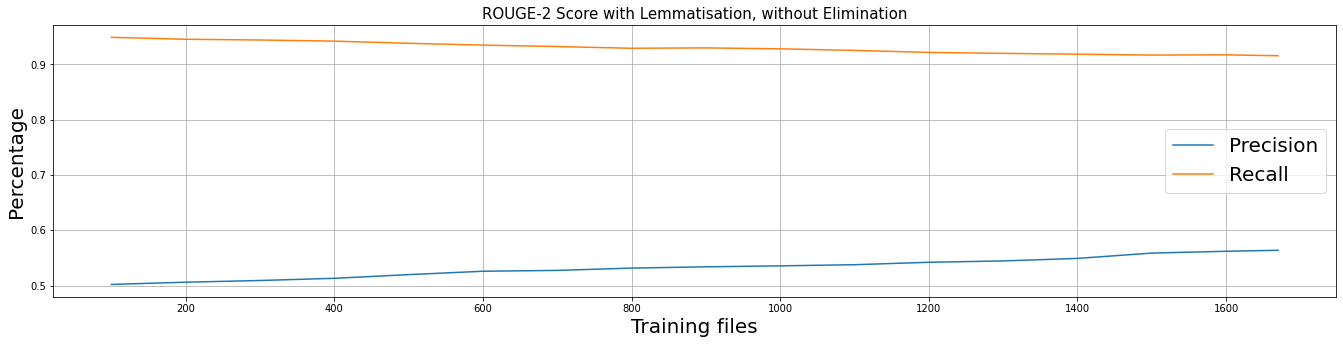

 Precision with Lemmatisation, without Elimination is: 0.5638518848800324
 Recall with Lemmatisation, without Elimination is: 0.9157021647744044


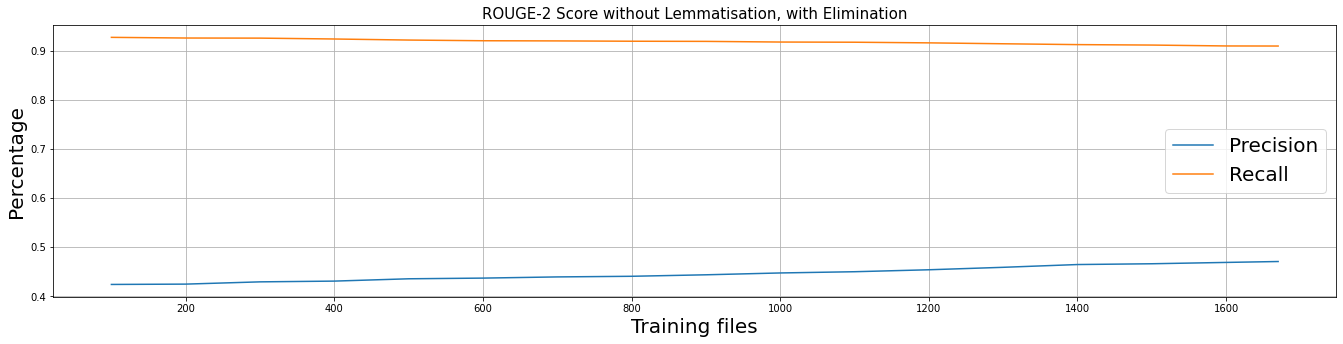

 Precision without Lemmatisation, with Elimination is: 0.47103114063171964
 Recall without Lemmatisation, with Elimination is: 0.9091453404204307


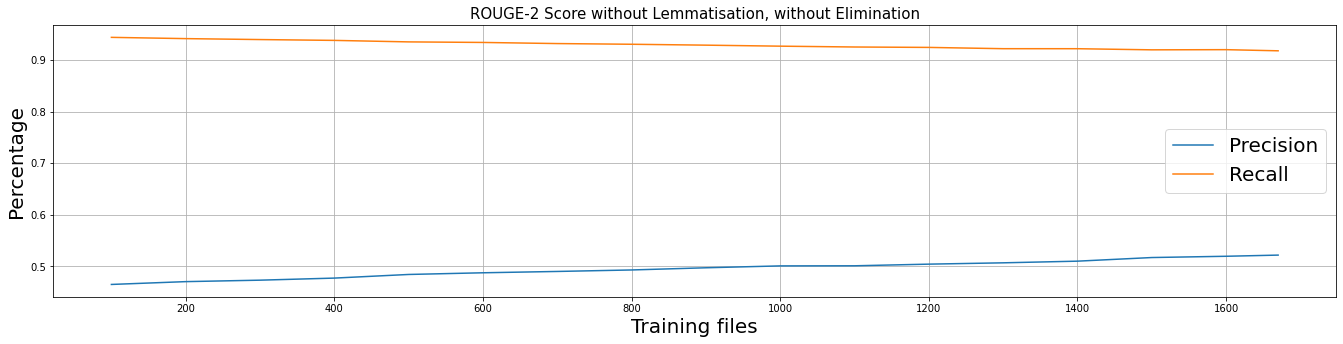

 Precision without Lemmatisation, without Elimination is: 0.5218509547312257
 Recall without Lemmatisation, without Elimination is: 0.9179470469018927


In [4]:
train_and_test('BBC News Summary', 'stop_words', True, True, 1)
train_and_test('BBC News Summary', 'stop_words', False, True, 1)
train_and_test('BBC News Summary', 'stop_words', True, False, 1)
train_and_test('BBC News Summary', 'stop_words', False, False, 1)

train_and_test('BBC News Summary', 'stop_words', True, True, 2)
train_and_test('BBC News Summary', 'stop_words', False, True, 2)
train_and_test('BBC News Summary', 'stop_words', True, False, 2)
train_and_test('BBC News Summary', 'stop_words', False, False, 2)